In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# Random Groups, Target+Count Encoding
Make random groups to match NAICS counts.   Then do the target-count encoding

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_target_count_encoder
from sba_gnn.sba_gnn.sg_target_count_encoder import TargetCountEncoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [9]:
naics_loans = pd.read_parquet(Path(setup.temp_path).joinpath('42_DATA_naics_groups_loans.parquet'))

In [10]:
sba_loans = sba_loans.merge(naics_loans.drop(columns=['dset', 'dset_naics_holdout', 'NAICS'],
                                             errors='ignore'),
                            on=['LoanNr_ChkDgt'])

##### Comparison metrics

In [11]:
metrics_base = pd.read_csv(Path(setup.temp_path).joinpath('A42_REPORT_metrics.csv'))

In [12]:
# Regular, non-hierarchical target encoding, for a horizontal reference line
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

## Encode NAICS and Groups

In [13]:
def get_metrics(data, enc_features = ['NAICS', 'NAICS_sector'],
               save_info = False):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:TargetCountEncoder(lambda_k = setup.selected_lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[f], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[f]) for f in enc_features],
                    axis=1, keys=enc_features)
    enc_val.columns = [c[0] + '_' + c[1] for c in enc_val.columns]
    
    predictor_features = setup.predictor_features + list(enc_val.columns)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), 
                       enc_val], axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Save info for Shapley (optional)
    if save_info:
        pd.concat([data[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=enc_val.columns, errors='ignore'), enc_val], axis = 1) \
            .to_parquet(Path(setup.temp_path).joinpath('A43_DATA_encodings.parquet'))
        with open(Path(setup.temp_path).joinpath('A43_DATA_features_predict.pkl'), 'wb') as fout:
            pickle.dump(predictor_features, fout)
        xgb_model.save_model(Path(setup.temp_path).joinpath('A43_MODEL_xgboost.json'))
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [14]:
# Hierarchical encode from different levels
enc_features = sorted([c for c in sba_loans.columns if c.startswith('rgrp')], reverse=True)
enc_features

['rgrp_834', 'rgrp_354', 'rgrp_106', 'rgrp_020']

In [15]:
# Hierarchical encode from different levels
feature_sets = [['NAICS'] + enc_features[i:] \
              for i in range(len(enc_features))]
feature_sets

[['NAICS', 'rgrp_834', 'rgrp_354', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_354', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_106', 'rgrp_020'],
 ['NAICS', 'rgrp_020']]

In [16]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
save_info = True  # Save first model only
for this_set in feature_sets:
    this_pred, this_met = get_metrics(sba_loans, this_set, save_info = save_info)
    this_pred['c'] = this_set[1]
    pred_df = pd.concat([pred_df, this_pred])
    this_met['c'] = this_set[1]
    metrics_df = pd.concat([metrics_df, this_met])
    save_info = False

In [17]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
0,test,0.661527,0.450031,0.337973,0.673256,0.384508,0.729540,0.0,rgrp_834
0,test,0.661409,0.450060,0.337927,0.673568,0.384088,0.729154,0.0,rgrp_354
0,test,0.661067,0.449063,0.337314,0.671539,0.384057,0.729273,0.0,rgrp_106
0,test,0.660778,0.449752,0.337475,0.673984,0.384205,0.728904,0.0,rgrp_020


In [18]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,c
1,test,0.640441,0.420695,0.297426,0.718467,0.346407,0.728843,1.0,rgrp_834
1,test,0.640088,0.422058,0.297978,0.723204,0.346827,0.728976,1.0,rgrp_354
1,test,0.641671,0.421789,0.298389,0.719228,0.347456,0.729195,1.0,rgrp_106
1,test,0.639089,0.421239,0.297234,0.722781,0.345445,0.728415,1.0,rgrp_020


In [19]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A43_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A43_REPORT_metrics.csv'), index=True)

## Comparison Plot

In [20]:
col_map = {f:int(f.replace('rgrp_', '')) for f in enc_features}
label_k = sorted([int(c) for c in col_map.values()])

In [21]:
col_map

{'rgrp_834': 834, 'rgrp_354': 354, 'rgrp_106': 106, 'rgrp_020': 20}

In [22]:
metrics_sum = metrics_df[~metrics_df['dset_naics_holdout'].isna()].copy()
metrics_sum['k'] = metrics_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [23]:
metrics_base_sum = metrics_base[~metrics_base['dset_naics_holdout'].isna()].copy()
metrics_base_sum['k'] = metrics_base_sum['c'].apply(lambda x: col_map[x]).astype('int')

In [24]:
# Reference lines
hline_test = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 0) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
hline_ho = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 1) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
print(f'Regular target encoding test result: {hline_test}; holdout {hline_ho}')

Regular target encoding test result: 0.382950251407698; holdout 0.346336505844941


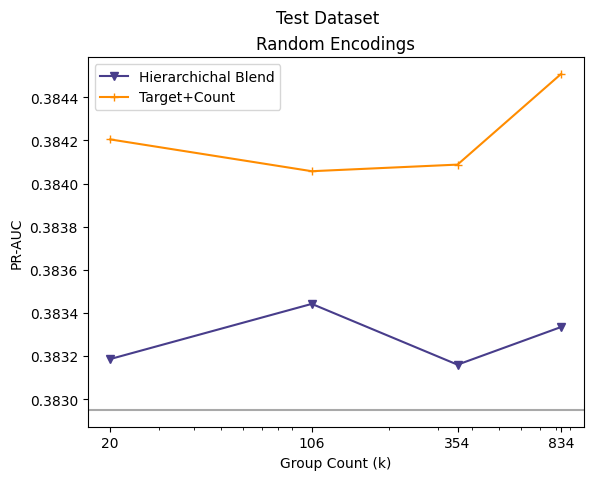

In [25]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Test Dataset')
ax.set_title('Random Encodings')
plt.axhline(y=hline_test, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A43_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

In [26]:
hline_test

0.382950251407698

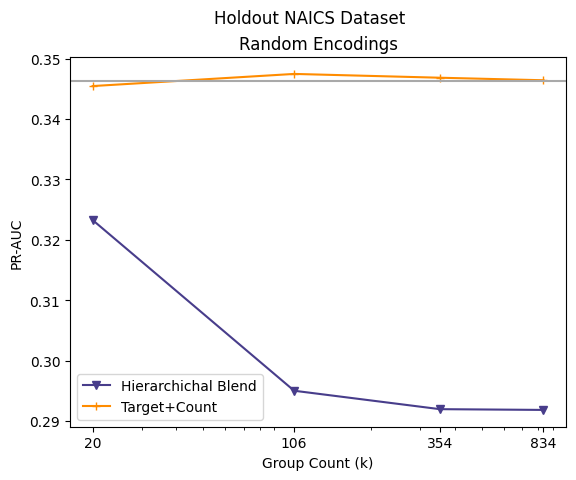

In [27]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Hierarchichal Blend',color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label='Target+Count',color='darkorange', style='+-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Holdout NAICS Dataset')
ax.set_title('Random Encodings')
plt.axhline(y=hline_ho, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(label_k)
fig.savefig(Path(setup.temp_path).joinpath('A43_PLOT_compare_base_ho.png'),
            bbox_inches='tight')